# Air Quality Dataset Analysis

In [224]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from scipy.stats import chi2_contingency

# Constants
On the oficial dataset description (check pdf in data directory), variables containing average values are considered categorical (a feature containing mean values is inherently numerical, not categorical). Taking this into account all variables (apart from the date), are considered as numerical (all tranformed to float to make further computation simpler).

In [225]:
COLUMNS_NUMERICAL = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']

# Loading the dataset

In [226]:
data = pd.read_csv("./data/AirQualityUCI.csv", sep=";")
data[COLUMNS_NUMERICAL] = data[COLUMNS_NUMERICAL].applymap(lambda x: x.replace(',', '.') if isinstance(x, str) and ',' in x else x).astype('float64')
data['Combined_Date'] = pd.to_datetime(data['Date'].str.strip() + ' ' + data['Time'].str.strip(), 
                                   format='%d/%m/%Y %H.%M.%S')
data.drop(['Date', 'Time'], axis=1, inplace=True)
data

/tmp/ipykernel_9439/2670207874.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data[COLUMNS_NUMERICAL] = data[COLUMNS_NUMERICAL].applymap(lambda x: x.replace(',', '.') if isinstance(x, str) and ',' in x else x).astype('float64')


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16,Combined_Date
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN,2004-03-10 18:00:00
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN,2004-03-10 19:00:00
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN,2004-03-10 20:00:00
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN,2004-03-10 21:00:00
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN,2004-03-10 22:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


# Task 1: Data Quality Control

## Step 1.1: Recognition of missing values

In [227]:
def df_missing_values_info(df):
    missing_values = df.isnull().sum()
    missing_values_percentage = (missing_values / len(df)) * 100
    print("Missing values in each column:")
    print(missing_values)
    print("\nPercentage of missing values:")
    print(missing_values_percentage)

df_missing_values_info(data)

Missing values in each column:
CO(GT)            114
PT08.S1(CO)       114
NMHC(GT)          114
C6H6(GT)          114
PT08.S2(NMHC)     114
NOx(GT)           114
PT08.S3(NOx)      114
NO2(GT)           114
PT08.S4(NO2)      114
PT08.S5(O3)       114
T                 114
RH                114
AH                114
Unnamed: 15      9471
Unnamed: 16      9471
Combined_Date     114
dtype: int64

Percentage of missing values:
CO(GT)             1.203674
PT08.S1(CO)        1.203674
NMHC(GT)           1.203674
C6H6(GT)           1.203674
PT08.S2(NMHC)      1.203674
NOx(GT)            1.203674
PT08.S3(NOx)       1.203674
NO2(GT)            1.203674
PT08.S4(NO2)       1.203674
PT08.S5(O3)        1.203674
T                  1.203674
RH                 1.203674
AH                 1.203674
Unnamed: 15      100.000000
Unnamed: 16      100.000000
Combined_Date      1.203674
dtype: float64


The dataset shows that most columns have 114 missing values, accounting for about **1.20% of the total rows**, which is manageable. However, `Unnamed: 15` and `Unnamed: 16` are entirely missing (100%) and should be dropped as they provide no information. The remaining columns with missing data, such as `CO(GT)`, `PT08.S1(CO)`, and others, require attention. These missing values are very probably the last 114 dataset rows (check the initial data visualization), which are all empty values too. Therefore, since no information is provided, these can all be dropped.

## Step 1.2: Recoding and Imputing Missing Values

### Remove empty rows & columns

Following the conclusions from the previous section (columns and rows only with empty values detected), empty rows and columns will be dropped.

In [228]:
data = data.dropna(how="all", axis=0)
data = data.dropna(how="all", axis=1)
df_missing_values_info(data)

Missing values in each column:
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
Combined_Date    0
dtype: int64

Percentage of missing values:
CO(GT)           0.0
PT08.S1(CO)      0.0
NMHC(GT)         0.0
C6H6(GT)         0.0
PT08.S2(NMHC)    0.0
NOx(GT)          0.0
PT08.S3(NOx)     0.0
NO2(GT)          0.0
PT08.S4(NO2)     0.0
PT08.S5(O3)      0.0
T                0.0
RH               0.0
AH               0.0
Combined_Date    0.0
dtype: float64


### Recoding -200 values
As defined on the explanation missing values are marked as -200, so these also need to be managed.

In [229]:
data.replace(-200, np.nan, inplace=True)
df_missing_values_info(data)

Missing values in each column:
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
Combined_Date       0
dtype: int64

Percentage of missing values:
CO(GT)           17.986534
PT08.S1(CO)       3.911510
NMHC(GT)         90.231912
C6H6(GT)          3.911510
PT08.S2(NMHC)     3.911510
NOx(GT)          17.516298
PT08.S3(NOx)      3.911510
NO2(GT)          17.548360
PT08.S4(NO2)      3.911510
PT08.S5(O3)       3.911510
T                 3.911510
RH                3.911510
AH                3.911510
Combined_Date     0.000000
dtype: float64


After replacing -200 with `NaN`, the missing values in the dataset increased significantly. The column `NMHC(GT)` now has the highest proportion of missing values at **90.23%**, which may make it unsuitable for analysis unless imputation or removal is justified. Columns like `CO(GT)`, `NOx(GT)`, and `NO2(GT)` have missing values around **17-18%**, which are substantial and require careful handling. The remaining columns, such as `PT08.S1(CO)`, `C6H6(GT)`, and others, have about **3.91% missing values**, which are manageable with standard cleaning techniques. 

Since after replacing -200 values, none of the features are completely empty imputation will be applied to all features.

### Imputing missing values using KNN Imputer

In [230]:
imputer = KNNImputer(n_neighbors=5)
data[COLUMNS_NUMERICAL] = imputer.fit_transform(data[COLUMNS_NUMERICAL])
df_missing_values_info(data)

Missing values in each column:
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
Combined_Date    0
dtype: int64

Percentage of missing values:
CO(GT)           0.0
PT08.S1(CO)      0.0
NMHC(GT)         0.0
C6H6(GT)         0.0
PT08.S2(NMHC)    0.0
NOx(GT)          0.0
PT08.S3(NOx)     0.0
NO2(GT)          0.0
PT08.S4(NO2)     0.0
PT08.S5(O3)      0.0
T                0.0
RH               0.0
AH               0.0
Combined_Date    0.0
dtype: float64


After applying the KNN imputation with 5 neighbors, all missing values in the dataset have been successfully filled, as indicated by **0 missing values** in every column. This transformation has resolved the issues from previous analyses, making the dataset complete and ready for further analysis or modeling. The imputation process has likely preserved data integrity by estimating missing values based on similar observations.

## Step 1.3: Recognition of uniform or illogical distributions

In [231]:
def check_distributions(data, columns):
    """
    Check for uniform or illogical distributions in numerical columns
    Returns summary statistics and flags potential issues
    """
    results = {}
    
    for col in columns:
        # Calculate basic statistics
        stats_dict = {
            'min': data[col].min(),
            'max': data[col].max(),
            'unique_values': data[col].nunique(),
            'zeros': (data[col] == 0).sum(),
            'negative_values': (data[col] < 0).sum()
        }
        
        # Check for potential uniform distribution
        hist, bin_edges = np.histogram(data[col], bins=30)
        uniformity_score = np.std(hist) / np.mean(hist)
        stats_dict['uniformity_score'] = uniformity_score
        
        # Flag potential issues
        issues = []
        if uniformity_score < 0.5:  # Threshold for suspiciously uniform distribution
            issues.append("Possibly uniform distribution")
        if stats_dict['negative_values'] > 0:
            issues.append("Contains negative values")
        if stats_dict['zeros'] / len(data) > 0.3:  # More than 30% zeros
            issues.append("High number of zeros")
            
        stats_dict['issues'] = issues
        results[col] = stats_dict
    
    return pd.DataFrame.from_dict(results, orient='index')

In [232]:
print("Distribution Analysis Results:")
distribution_analysis = check_distributions(data, COLUMNS_NUMERICAL)
print(distribution_analysis)

Distribution Analysis Results:
                    min       max  unique_values  zeros  negative_values  \
PT08.S1(CO)    647.0000  2040.000           1213      0                0   
PT08.S2(NMHC)  383.0000  2214.000           1407      0                0   
PT08.S3(NOx)   322.0000  2683.000           1382      0                0   
PT08.S4(NO2)   551.0000  2775.000           1752      0                0   
PT08.S5(O3)    221.0000  2523.000           1895      0                0   
CO(GT)           0.1000    11.900            437      0                0   
NMHC(GT)         7.0000  1189.000           1676      0                0   
NOx(GT)          2.0000  1479.000           1687      0                0   
NO2(GT)          2.0000   340.000            750      0                0   
C6H6(GT)         0.1000    63.700            582      0                0   
T               -1.9000    44.600            611      1               13   
RH               9.2000    88.700            926      0  

The distribution analysis highlights the following:

1. **General Observations**:
   - All columns have **no zeros** (except `T` with one zero) and **no negative values**, except for the `T` column, which has **13 negative values**. This indicates most features have clean, non-negative distributions, except for temperature, which may need further handling depending on the context.
   - The range (min to max) and number of unique values indicate a good level of variability across columns.

2. **Uniformity Scores**:
   - Columns like `PT08.S2(NMHC)` and `PT08.S1(CO)` have high uniformity scores (close to 1), suggesting a relatively even spread of values.
   - Higher scores in other columns (e.g., `NMHC(GT)` and `CO(GT)`) indicate more uniform distributions, while lower scores (e.g., `RH` and `T`) may reflect more concentrated or skewed distributions.

3. **Issues Identified**:
   - The only flagged issue is that `T` (temperature) contains **13 negative values**, which may need to be examined for data validity. If these values are not realistic for the dataset context, they could be replaced or adjusted.

Moreover, the `'T'` feature has some below 0 values. However, since this the used units are Cº (check oficial dataset explanation page), negative values can be permitted.

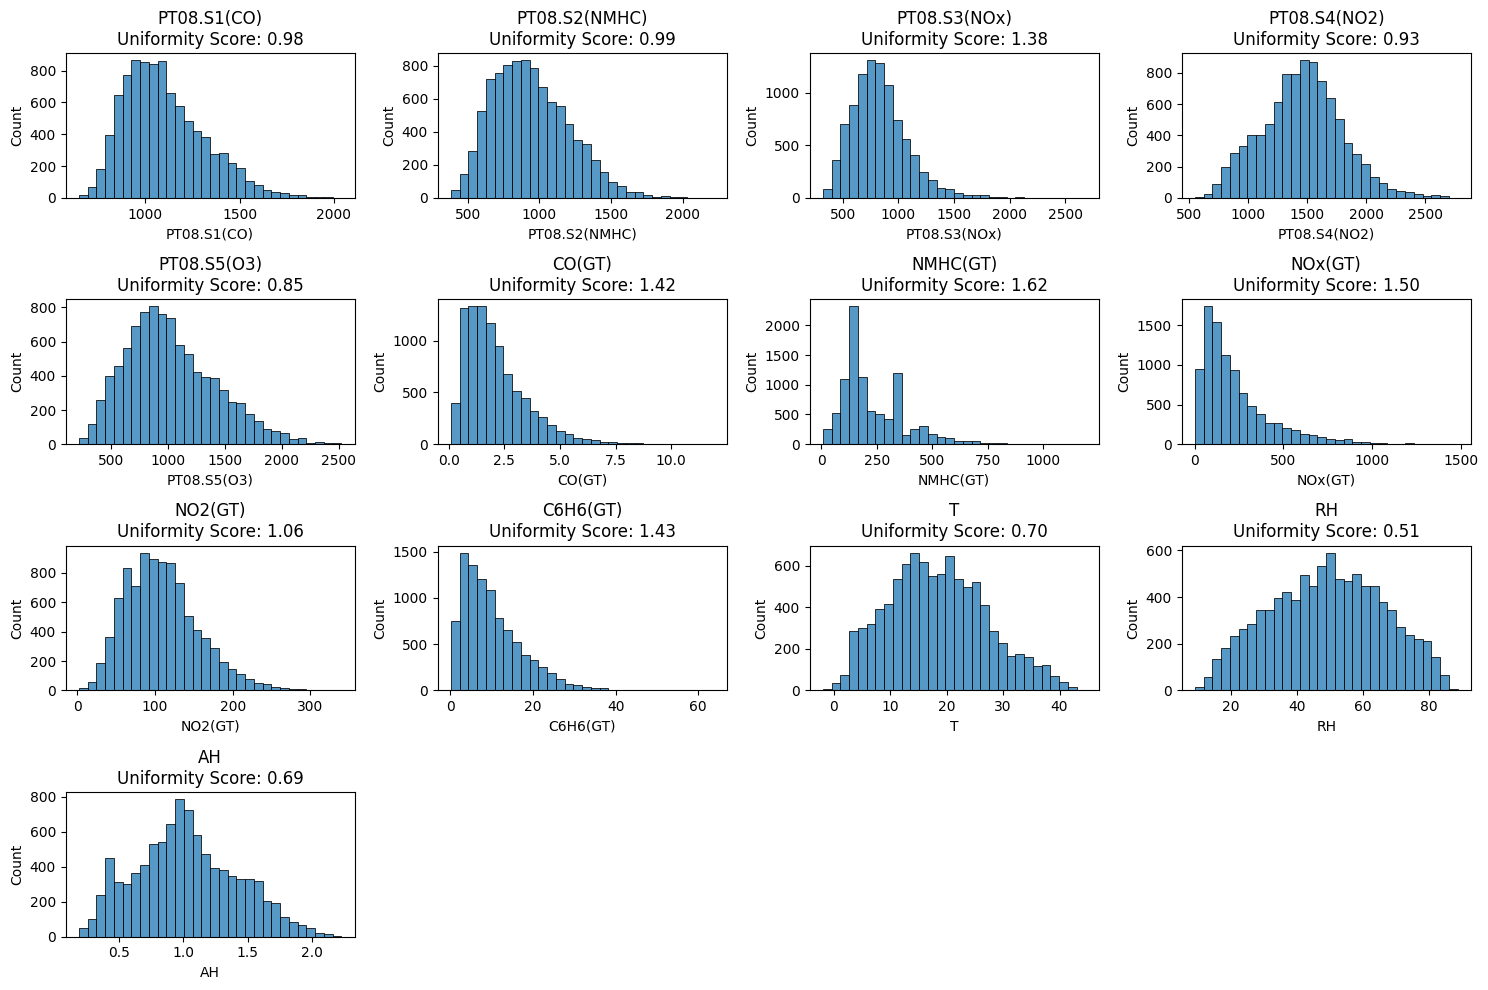

In [233]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(COLUMNS_NUMERICAL, 1):
    plt.subplot(4, 4, i)
    sns.histplot(data[col], bins=30)
    plt.title(f'{col}\nUniformity Score: {distribution_analysis.loc[col, "uniformity_score"]:.2f}')
plt.tight_layout()
plt.show()

Following observations can be made from the previous plot:

1. **Well-Distributed Columns**: 
   - Columns like `PT08.S1(CO)`, `PT08.S2(NMHC)`, and `PT08.S4(NO2)` show balanced distributions with high uniformity scores (close to or above 0.90). These distributions suggest that the values are evenly spread and likely do not require significant transformations. However, we can appreciate how they are slightly skewed to the left.

2. **Skewed Distributions**:
   - `CO(GT)`, `NOx(GT)`, and `NMHC(GT)` display skewed distributions with higher uniformity scores (above 1.4). These may benefit from transformations (e.g., logarithmic or Box-Cox) for modeling purposes.

3. **Special Cases**:
   - `T` (Temperature) shows a nearly symmetrical distribution but includes a few negative values (flagged earlier). Its uniformity score (0.70) and visualization suggest it is fairly distributed apart from the negative values.
   - `RH` (Relative Humidity) and `AH` (Absolute Humidity) have lower uniformity scores (0.51 and 0.69), with slight clustering, indicating potential areas for exploration.

Overall, the histograms and uniformity scores reveal a mix of well-distributed, skewed, and clustered variables. Preprocessing steps like normalization or transformations might help standardize skewed features for better analysis and modeling. However, none of these are illogical nor uniform.

## Step 1.4: Check / redesign / determine the target variable and its quality

In [234]:
def create_binary_target(data, target_column, threshold_method='median'):
    """
    Transform a continuous target variable into binary
    Methods: 'median', 'mean', 'percentile'
    Returns: transformed data and threshold used
    """
    if threshold_method == 'median':
        threshold = data[target_column].median()
    elif threshold_method == 'mean':
        threshold = data[target_column].mean()
    elif threshold_method == 'percentile':
        threshold = data[target_column].quantile(0.75)  # 75th percentile
    
    binary_target = (data[target_column] > threshold).astype(int)
    return binary_target, threshold

def analyze_binary_target(data, binary_target, original_target, threshold):
    """
    Analyze the quality of the binary target variable
    """
    print(f"\nBinary Target Analysis")
    print("-" * 50)
    
    # Class distribution
    class_dist = binary_target.value_counts(normalize=True)
    print("\nClass Distribution:")
    print(class_dist)
    
    # Calculate class balance ratio
    balance_ratio = min(class_dist) / max(class_dist)
    print(f"\nClass Balance Ratio: {balance_ratio:.2f}")
    
    # Visualize class distribution
    plt.figure(figsize=(12, 4))
    
    # Bar plot of class distribution
    plt.subplot(1, 2, 1)
    sns.countplot(x=binary_target)
    plt.title('Binary Target Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    
    # Original variable distribution with threshold
    plt.subplot(1, 2, 2)
    sns.histplot(data[original_target], bins=30)
    plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
    plt.title(f'Original {original_target} Distribution\nwith Binary Threshold')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return {
        'balance_ratio': balance_ratio,
        'class_distribution': class_dist
    }

As can be seen in the following code cell, the following features are chosen as potential targets for the following reasons:

**CO(GT)**: Key indicator of incomplete combustion from vehicles and industry, measured in mg/m³ with ground truth data.

**C6H6(GT)**: Benzene is a hazardous organic compound commonly from vehicle emissions, with accurate reference measurements in μg/m³.

**NO2(GT)**: Critical urban air pollutant directly linked to respiratory issues, measured in μg/m³ by reference analyzer.

**NOx(GT)**: Family of nitrogen oxide gases that form smog and acid rain, measured in ppb as ground truth from traffic and industrial sources.

Binary Target Variable Analysis

Analyzing CO(GT)
--------------------------------------------------

Binary Target Analysis
--------------------------------------------------

Class Distribution:
CO(GT)
0    0.50016
1    0.49984
Name: proportion, dtype: float64

Class Balance Ratio: 1.00


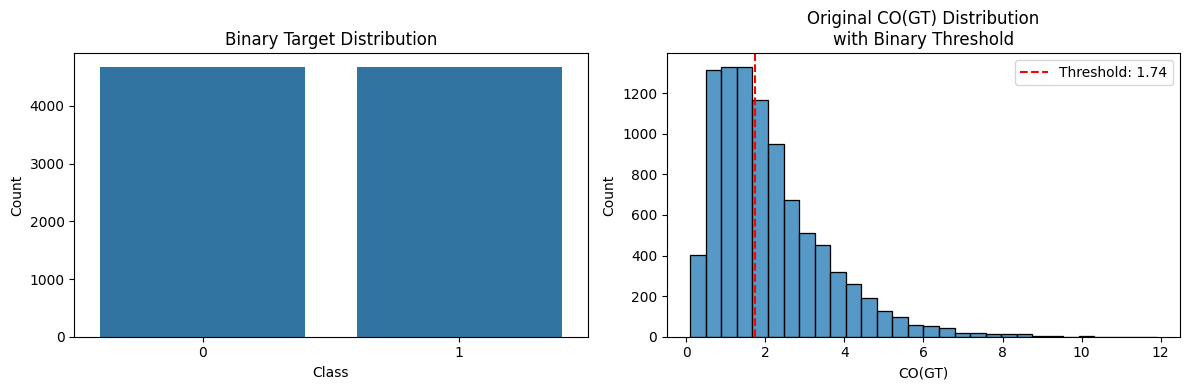


Binary Target Analysis
--------------------------------------------------

Class Distribution:
CO(GT)
0    0.592925
1    0.407075
Name: proportion, dtype: float64

Class Balance Ratio: 0.69


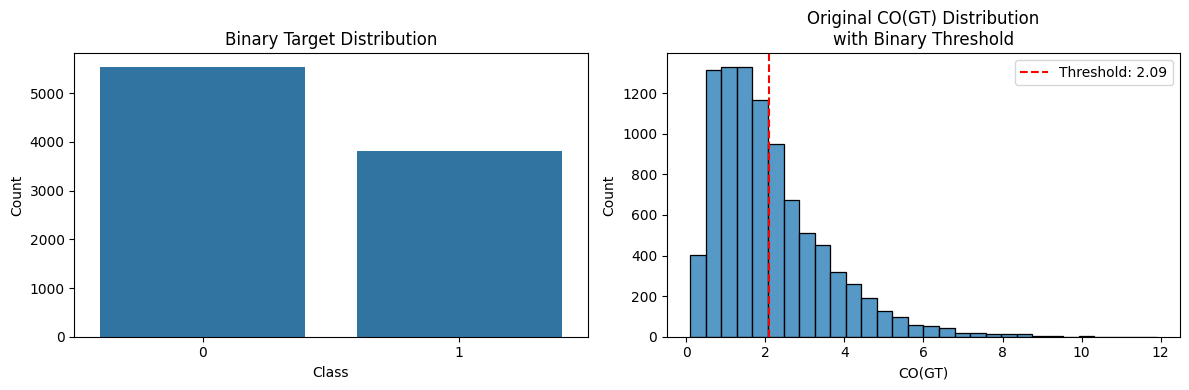


Binary Target Analysis
--------------------------------------------------

Class Distribution:
CO(GT)
0    0.750027
1    0.249973
Name: proportion, dtype: float64

Class Balance Ratio: 0.33


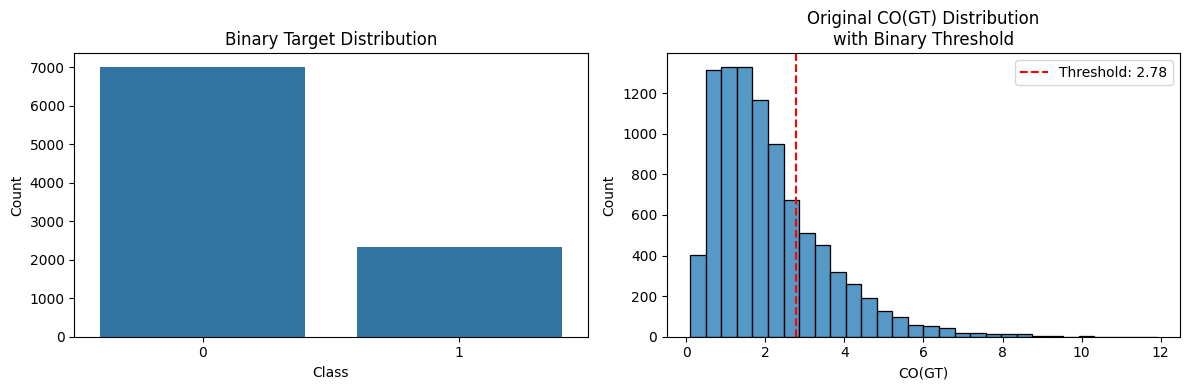


Analyzing C6H6(GT)
--------------------------------------------------

Binary Target Analysis
--------------------------------------------------

Class Distribution:
C6H6(GT)
0    0.500053
1    0.499947
Name: proportion, dtype: float64

Class Balance Ratio: 1.00


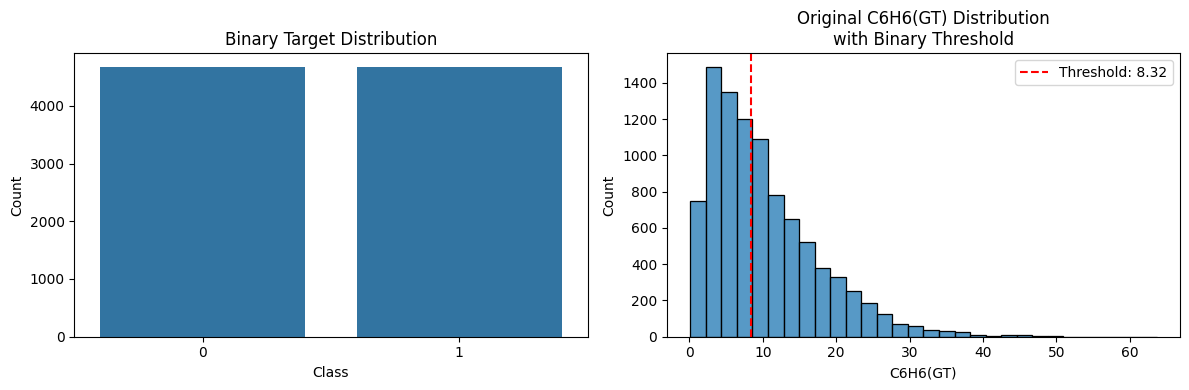


Binary Target Analysis
--------------------------------------------------

Class Distribution:
C6H6(GT)
0    0.601047
1    0.398953
Name: proportion, dtype: float64

Class Balance Ratio: 0.66


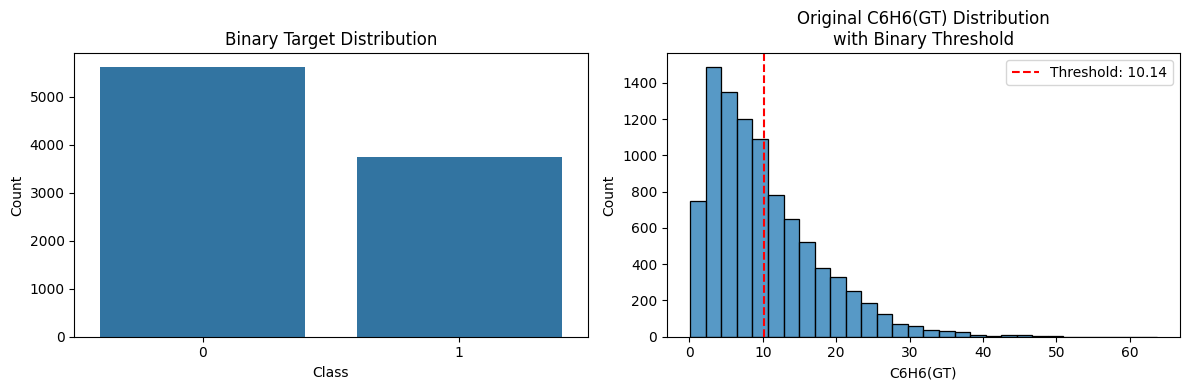


Binary Target Analysis
--------------------------------------------------

Class Distribution:
C6H6(GT)
0    0.751309
1    0.248691
Name: proportion, dtype: float64

Class Balance Ratio: 0.33


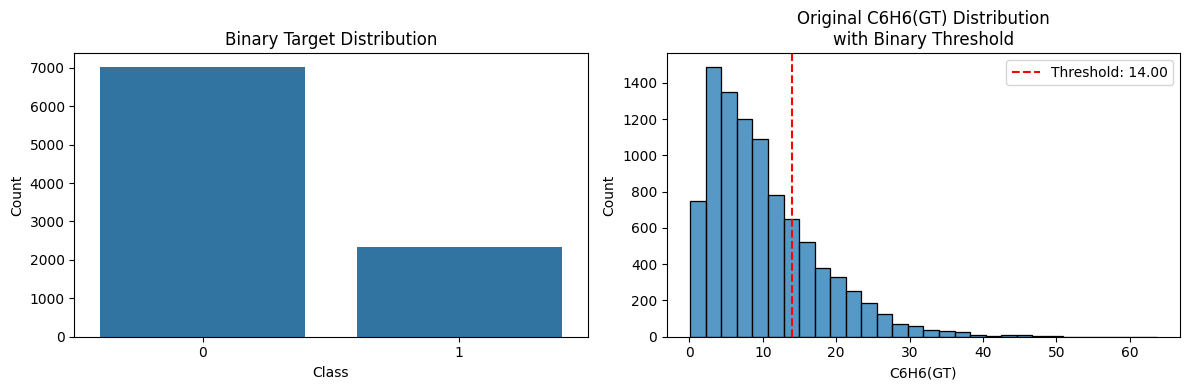


Analyzing NO2(GT)
--------------------------------------------------

Binary Target Analysis
--------------------------------------------------

Class Distribution:
NO2(GT)
0    0.502405
1    0.497595
Name: proportion, dtype: float64

Class Balance Ratio: 0.99


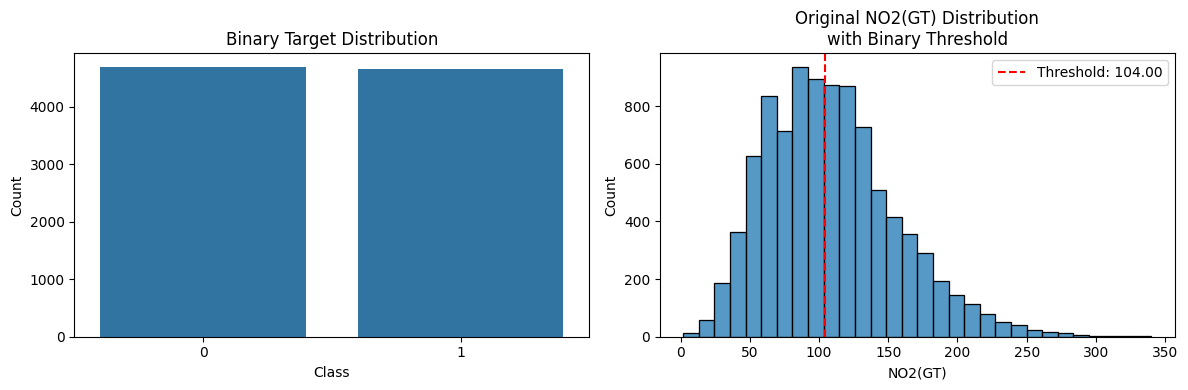


Binary Target Analysis
--------------------------------------------------

Class Distribution:
NO2(GT)
0    0.534466
1    0.465534
Name: proportion, dtype: float64

Class Balance Ratio: 0.87


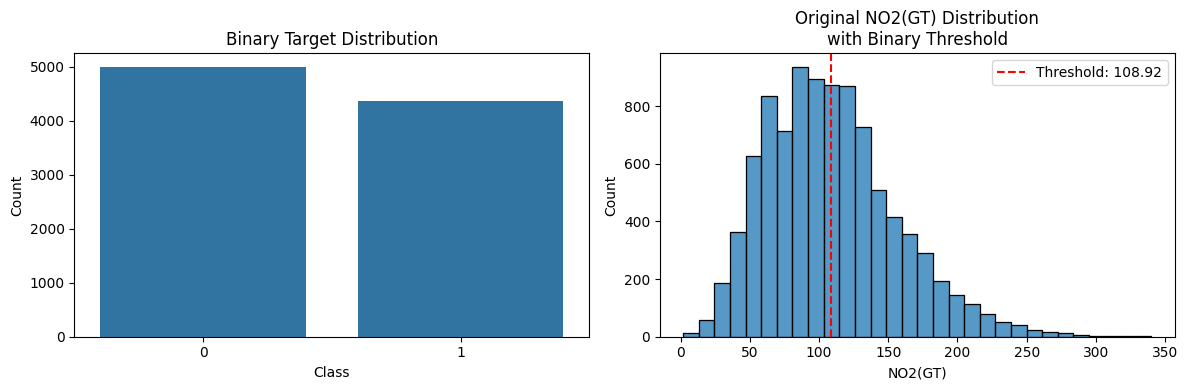


Binary Target Analysis
--------------------------------------------------

Class Distribution:
NO2(GT)
0    0.751416
1    0.248584
Name: proportion, dtype: float64

Class Balance Ratio: 0.33


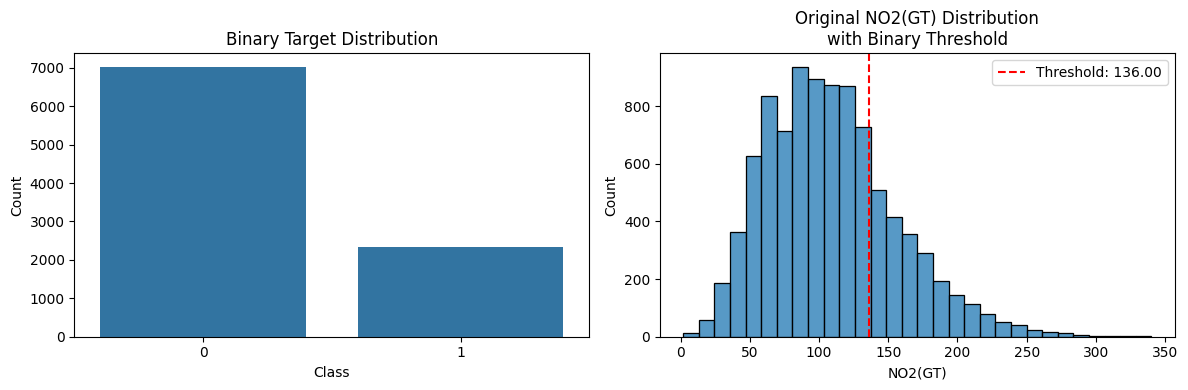


Analyzing NOx(GT)
--------------------------------------------------

Binary Target Analysis
--------------------------------------------------

Class Distribution:
NOx(GT)
0    0.500802
1    0.499198
Name: proportion, dtype: float64

Class Balance Ratio: 1.00


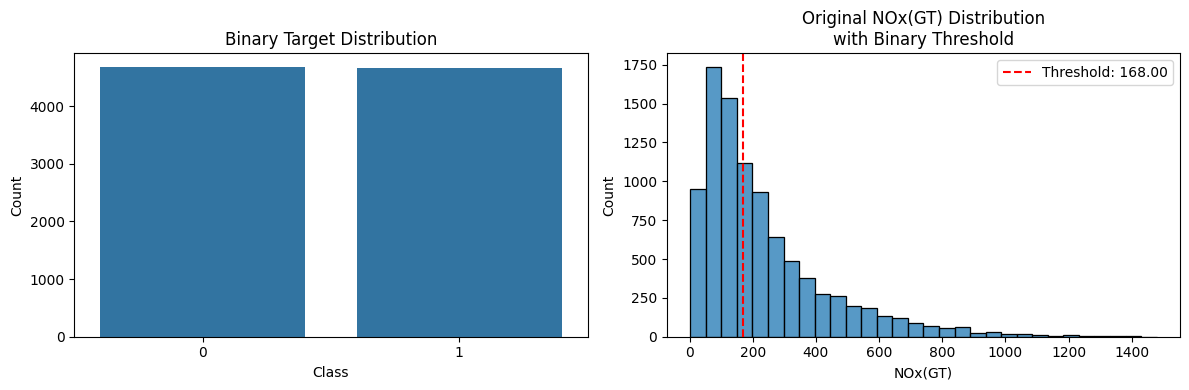


Binary Target Analysis
--------------------------------------------------

Class Distribution:
NOx(GT)
0    0.64262
1    0.35738
Name: proportion, dtype: float64

Class Balance Ratio: 0.56


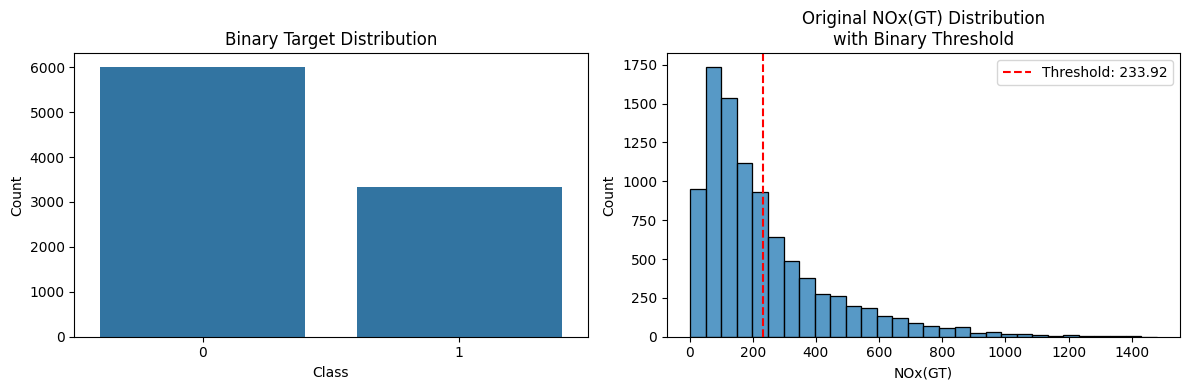


Binary Target Analysis
--------------------------------------------------

Class Distribution:
NOx(GT)
0    0.750134
1    0.249866
Name: proportion, dtype: float64

Class Balance Ratio: 0.33


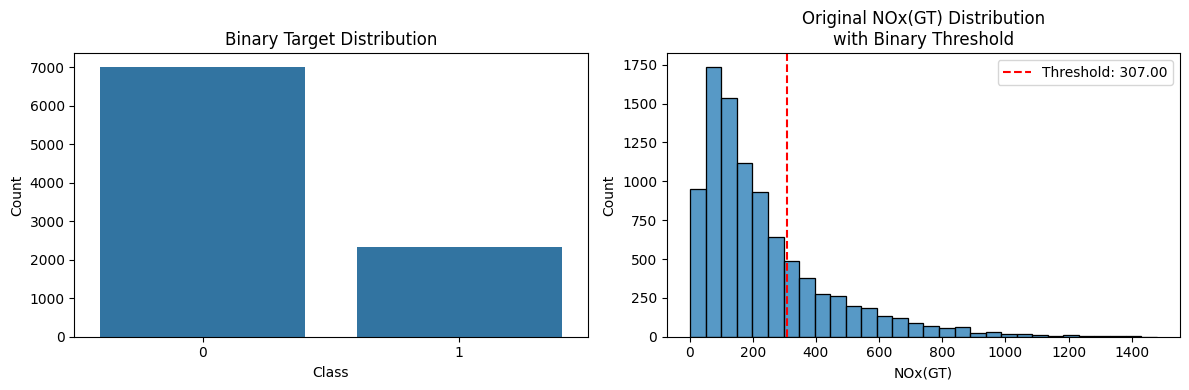

In [235]:
# Analyze potential target variables for binarization
potential_targets = ['CO(GT)', 'C6H6(GT)', 'NO2(GT)', 'NOx(GT)']
binary_analyses = {}
threshold_methods = ['median', 'mean', 'percentile']

print("Binary Target Variable Analysis")
print("=" * 50)

for target in potential_targets:
    print(f"\nAnalyzing {target}")
    print("-" * 50)
    
    method_results = {}
    for method in threshold_methods:
        # Create binary target
        binary_target, threshold = create_binary_target(data, target, method)
        
        # Analyze binary target
        analysis_results = analyze_binary_target(data, binary_target, target, threshold)
        method_results[method] = {
            'threshold': threshold,
            'balance_ratio': analysis_results['balance_ratio'],
            'class_distribution': analysis_results['class_distribution']
        }
    
    binary_analyses[target] = method_results

In [236]:
# Compare and select the best target variable and threshold method
results_df = pd.DataFrame(columns=['Target', 'Method', 'Balance_Ratio', 'Threshold'])

for target, methods in binary_analyses.items():
    for method, results in methods.items():
        new_row = pd.DataFrame({
            'Target': [target],
            'Method': [method],
            'Balance_Ratio': [results['balance_ratio']],
            'Threshold': [results['threshold']]
        })
        results_df = pd.concat([results_df, new_row], ignore_index=True)

print("\nComparison of Binary Target Options:")
print(results_df.sort_values('Balance_Ratio', ascending=False))

# Select the best combination based on balance ratio
best_combination = results_df.loc[results_df['Balance_Ratio'].idxmax()]
print(f"\nRecommended Binary Target Configuration:")
print(f"Target Variable: {best_combination['Target']}")
print(f"Threshold Method: {best_combination['Method']}")
print(f"Balance Ratio: {best_combination['Balance_Ratio']:.2f}")
print(f"Threshold Value: {best_combination['Threshold']:.2f}")


Comparison of Binary Target Options:
      Target      Method  Balance_Ratio   Threshold
3   C6H6(GT)      median       0.999786    8.320000
0     CO(GT)      median       0.999359    1.740000
9    NOx(GT)      median       0.996799  168.000000
6    NO2(GT)      median       0.990428  104.000000
7    NO2(GT)        mean       0.871026  108.923376
1     CO(GT)        mean       0.686554    2.087111
4   C6H6(GT)        mean       0.663762   10.144287
10   NOx(GT)        mean       0.556128  233.918435
2     CO(GT)  percentile       0.333286    2.780000
11   NOx(GT)  percentile       0.333096  307.000000
5   C6H6(GT)  percentile       0.331010   14.000000
8    NO2(GT)  percentile       0.330821  136.000000

Recommended Binary Target Configuration:
Target Variable: C6H6(GT)
Threshold Method: median
Balance Ratio: 1.00
Threshold Value: 8.32


/tmp/ipykernel_9439/1233042504.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


In [237]:
# Create final binary target variable and drop the feature used to compute this value
binary_target, threshold = create_binary_target(
    data, 
    best_combination['Target'], 
    best_combination['Method']
)
data['target_binary'] = binary_target
data.drop(columns=[best_combination['Target']], inplace=True)
data

,CO(GT),PT08.S1(CO),NMHC(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Combined_Date,target_binary
0,2.6,1360.0,150.0,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00,1
1,2.0,1292.0,112.0,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00,1
2,2.2,1402.0,88.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00,1
3,2.2,1376.0,80.0,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00,1
4,1.6,1272.0,51.0,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.1,1314.0,323.2,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568,2005-04-04 10:00:00,1
9353,2.4,1163.0,323.2,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119,2005-04-04 11:00:00,1
9354,2.4,1142.0,323.2,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406,2005-04-04 12:00:00,1
9355,2.1,1003.0,305.2,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139,2005-04-04 13:00:00,1


## Step 1.5: Explain / comment on the findings

This section emphasizes the findings on the target variable selection and binarization. For other comments in dataset feature distributions, missing value... go to previous corresponding sections.

In [238]:
print("\nKey Findings from Binary Target Analysis:")
print("-" * 50)
print(f"\n1. Selected Target Variable: {best_combination['Target']}")
print(f"   - Threshold Method: {best_combination['Method']}")
print(f"   - Threshold Value: {best_combination['Threshold']:.2f}")
print(f"   - Class Balance Ratio: {best_combination['Balance_Ratio']:.2f}")

print("\n2. Class Distribution:")
class_counts = data['target_binary'].value_counts()
for class_label, count in class_counts.items():
    print(f"   Class {class_label}: {count} samples ({count/len(data)*100:.1f}%)")

print("\n3. Recommendations:")
if best_combination['Balance_Ratio'] < 0.7:
    print("   - Consider class balancing techniques for modeling")
elif best_combination['Balance_Ratio'] < 0.3:
    print("   - Strong class imbalance detected - may need oversampling/undersampling")
else:
    print("   - No recommendations :)")


Key Findings from Binary Target Analysis:
--------------------------------------------------

1. Selected Target Variable: C6H6(GT)
   - Threshold Method: median
   - Threshold Value: 8.32
   - Class Balance Ratio: 1.00

2. Class Distribution:
   Class 0: 4679 samples (50.0%)
   Class 1: 4678 samples (50.0%)

3. Recommendations:
   - No recommendations :)


Further observations:

1. **Comparison of Options**:
   - The dataset evaluated several target variables (`C6H6(GT)`, `CO(GT)`, `NOx(GT)`, and `NO2(GT)`) using different threshold methods (`median`, `mean`, and `percentile`).
   - Among all combinations, the highest **balance ratio** (close to 1.00) was achieved by `C6H6(GT)` with the **median** threshold method, resulting in a balance ratio of **0.9998** and a threshold value of **8.32**.

2. **Recommended Configuration**:
   - The best binary target variable is **C6H6(GT)**.
   - The most effective threshold method is **median**.
   - This combination provides an optimal balance ratio (closest to 1), indicating that the binary classification will have a well-balanced distribution of classes.

3. **Other Observations**:
   - `CO(GT)` with the median threshold method is a close contender, with a balance ratio of **0.9994** and a threshold of **1.74**.
   - Using the `mean` or `percentile` methods generally results in significantly lower balance ratios (e.g., `NOx(GT)` with the percentile method achieves only **0.3331**).
   - Thresholds vary significantly depending on the method, reinforcing the importance of selecting the right combination for balanced binary classification.

# Task 2: Statistical analysis of sample data

## Step 2.1: For each continuous variable, calculate the mean value, Z values, roundness of the distribution, skewness of the distribution

In [239]:
# Remove the target variable from the COLUMNS_NUMERICAL array
COLUMNS_NUMERICAL_NON_TARGET = list(filter(lambda x : x != best_combination['Target'], COLUMNS_NUMERICAL))

Distribution Metrics for Continuous Variables:
                      mean                                      z_score_stats  \
PT08.S1(CO)    1100.341031  {'min': -2.1120868322798136, 'max': 4.37781096...   
PT08.S2(NMHC)   941.529160  {'min': -2.1020687310768906, 'max': 4.78904478...   
PT08.S3(NOx)    833.064455  {'min': -2.012079989734341, 'max': 7.283265857...   
PT08.S4(NO2)   1457.233879  {'min': -2.6507382182402877, 'max': 3.85447190...   
PT08.S5(O3)    1025.837522  {'min': -2.0381589098319086, 'max': 3.79139262...   
CO(GT)            2.087111  {'min': -1.4018314718081508, 'max': 6.92262221...   
NMHC(GT)        229.667710  {'min': -1.5114187490911293, 'max': 6.51173358...   
NOx(GT)         233.918435  {'min': -1.127313551757056, 'max': 6.052116207...   
NO2(GT)         108.923376  {'min': -2.2706079831677117, 'max': 4.90710681...   
T                18.384037  {'min': -2.3236169066900896, 'max': 3.00314260...   
RH               49.181330  {'min': -2.3373506952511613, 'max'

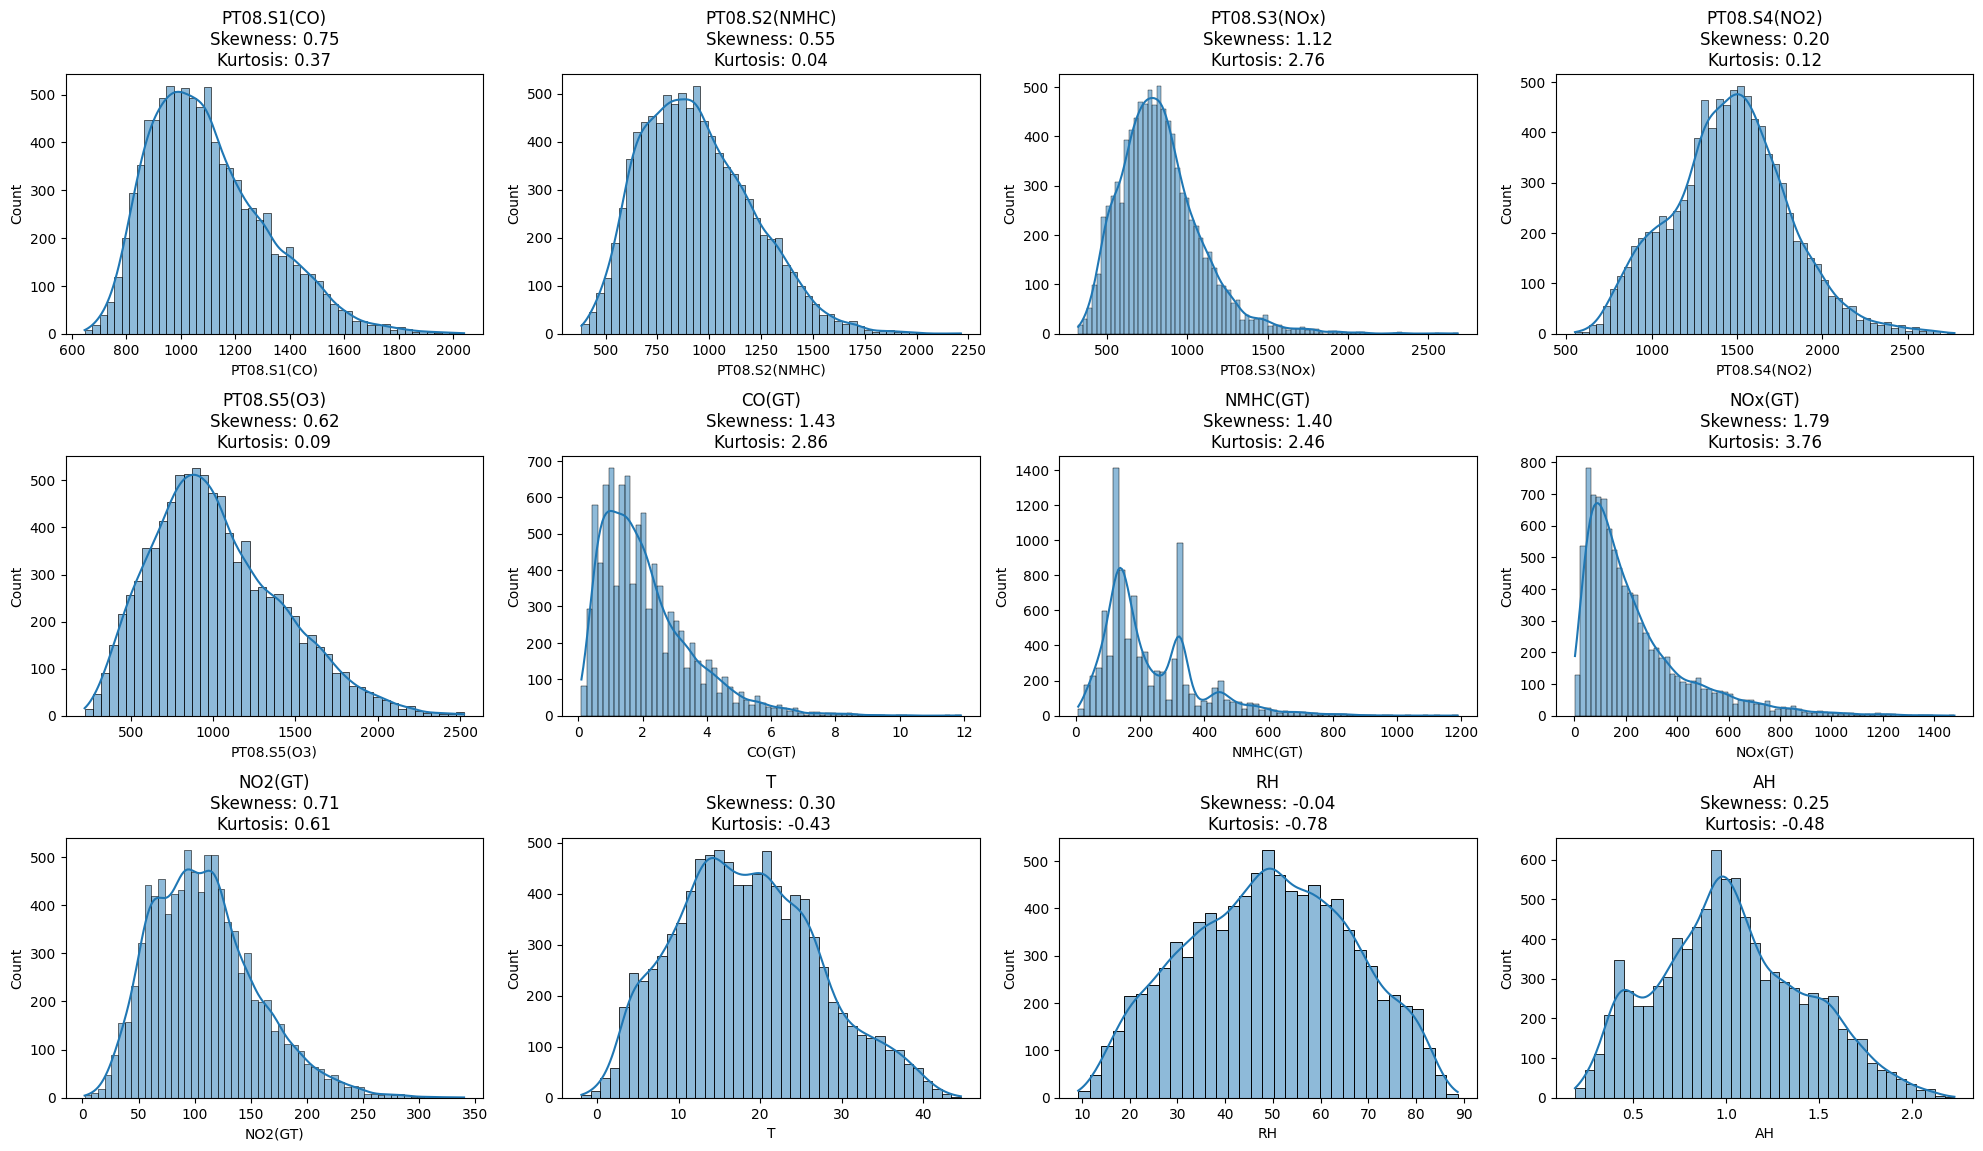

In [240]:
def calculate_distribution_metrics(data, columns):
    """
    Calculate distribution metrics for continuous variables
    Returns mean, Z-values, kurtosis (roundness), and skewness
    """
    results = {}
    for col in columns:
        # Calculate metrics
        mean = data[col].mean()
        std = data[col].std()
        z_scores = (data[col] - mean) / std
        kurtosis = data[col].kurtosis()
        skewness = data[col].skew()
        
        # Store results
        results[col] = {
            'mean': mean,
            'z_score_stats': {
                'min': z_scores.min(),
                'max': z_scores.max(),
                'outliers': len(z_scores[abs(z_scores) > 3])
            },
            'kurtosis': kurtosis,
            'skewness': skewness
        }
    
    return pd.DataFrame.from_dict(results, orient='index')

# Calculate distribution metrics
print("Distribution Metrics for Continuous Variables:")
distribution_metrics = calculate_distribution_metrics(data, COLUMNS_NUMERICAL_NON_TARGET)
print(distribution_metrics)

# Create visualizations for continuous variables
plt.figure(figsize=(20, 15))
for i, col in enumerate(COLUMNS_NUMERICAL_NON_TARGET, 1):
    plt.subplot(4, 4, i)
    sns.histplot(data[col], kde=True)
    plt.title(f'{col}\nSkewness: {distribution_metrics.loc[col, "skewness"]:.2f}\nKurtosis: {distribution_metrics.loc[col, "kurtosis"]:.2f}')
plt.tight_layout()
plt.show()

The distribution analysis of the numerical variables in the dataset highlights key insights regarding their statistical properties. Each variable was assessed for its mean, z-score statistics, kurtosis, and skewness. The z-score statistics revealed potential outliers, with extreme values (z-scores > ±3) detected in many variables. For instance, `PT08.S3(NOx)` showed a maximum z-score of 7.28, while `CO(GT)` had a value of 6.92. These extreme values suggest that outliers are a concern for heavy-tailed variables like `NOx(GT)` and `NMHC(GT)`.

Several variables displayed significant skewness, indicating asymmetry in their distributions. Notably, `NOx(GT)` (skewness: 1.79) and `CO(GT)` (1.43) exhibited substantial right skewness. In contrast, variables like `RH` (-0.04 skewness) and `AH` (0.25 skewness) were nearly symmetric. The skewness, combined with kurtosis values, provides further insight into the distribution shapes. Heavy-tailed variables, such as `NOx(GT)` (kurtosis: 3.76), `CO(GT)` (2.86), and `NMHC(GT)` (2.46), suggest the presence of extreme values, while lighter-tailed distributions are observed in `T` (-0.43 kurtosis) and `RH` (-0.78 kurtosis).

The visualizations, including histograms with KDE curves, confirm these observations. Variables such as `NOx(GT)` and `NMHC(GT)` clearly exhibit right-skewed distributions, while `T`, `RH`, and `AH` show relatively uniform and symmetric patterns. The plots also highlight the tail behavior and asymmetries, particularly for variables with significant skewness and kurtosis.

To improve the quality of the data, normalization or transformations should be applied to highly skewed variables like `CO(GT)`, `NOx(GT)`, and `NMHC(GT)`. Logarithmic or Box-Cox transformations could help reduce skewness and normalize their distributions. Additionally, extreme z-scores (> ±3) in heavy-tailed variables should be investigated, and outlier capping or removal may be necessary to ensure robust model performance. Finally, standardizing or scaling all continuous variables may enhance the performance of machine learning models, particularly those sensitive to variable magnitudes. 

## Step 2.2: Calculate correlations and Z-score class correlations

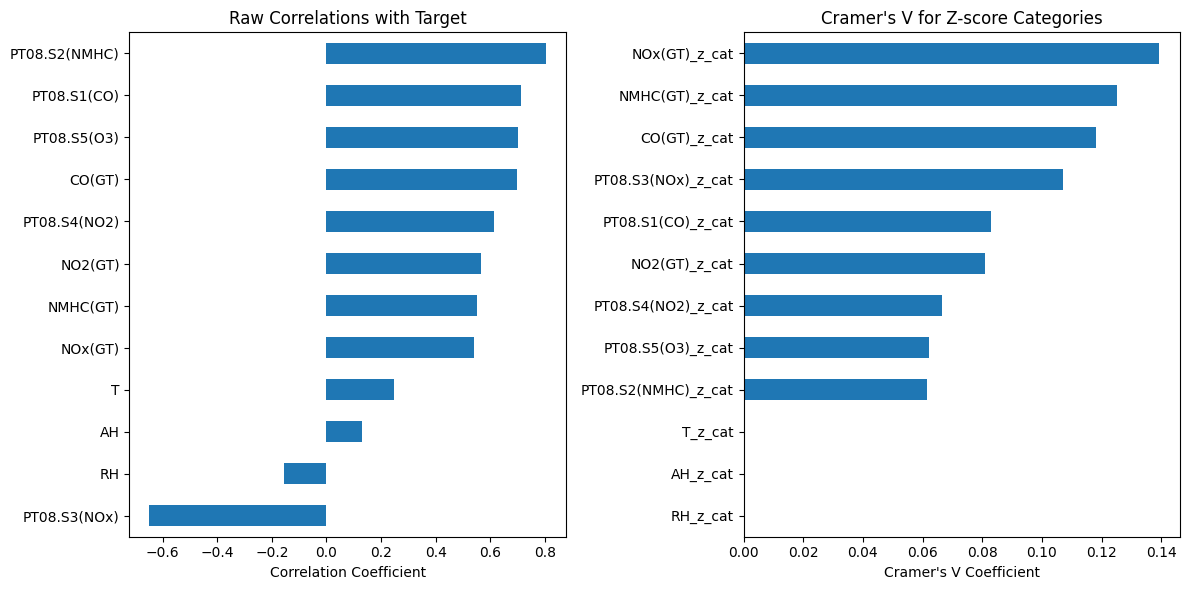

In [241]:
def categorize_z_scores(data, columns):
    """
    Categorize Z-scores into classes: <-3, (-3 to 3), >3
    Returns DataFrame with categorized Z-scores
    """
    z_categorized = pd.DataFrame()
    
    for col in columns:
        mean = data[col].mean()
        std = data[col].std()
        
        # Handle zero standard deviation
        if std == 0:
            z_cat = pd.Series('-3 to 3', index=data.index)
        else:
            z_scores = (data[col] - mean) / std
            z_cat = pd.cut(z_scores, 
                          bins=[-float('inf'), -3, 3, float('inf')],
                          labels=['< -3', '-3 to 3', '> 3'])
        
        z_categorized[f'{col}_z_cat'] = z_cat
    
    return z_categorized

def analyze_correlations(data, target, columns):
    """
    Calculate correlations with target variable for both raw values
    and Z-score categories
    """
    # Raw correlations
    raw_corr = data[columns].corrwith(data[target])
    
    # Z-score category correlations
    z_cats = categorize_z_scores(data, columns)
    z_corr = {}
    
    for col in z_cats.columns:
        cont_table = pd.crosstab(z_cats[col], data[target])
        
        try:
            chi2, p_value = chi2_contingency(cont_table)[:2]
            # Calculate Cramer's V with error handling
            n = len(data)
            min_dim = min(cont_table.shape[0]-1, cont_table.shape[1]-1)
            
            # Check if denominator would be zero
            if n == 0 or min_dim == 0:
                cramer_v = 0
            else:
                cramer_v = np.sqrt(chi2 / (n * min_dim))
        except:
            # Handle any statistical computation errors
            chi2, p_value, cramer_v = 0, 1, 0
            
        z_corr[col] = {'chi2': chi2, 'p_value': p_value, 'cramer_v': cramer_v}
    
    return raw_corr, pd.DataFrame.from_dict(z_corr, orient='index')

# Calculate correlations
raw_correlations, z_correlations = analyze_correlations(data, 'target_binary', COLUMNS_NUMERICAL_NON_TARGET)

# Plot correlation results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
raw_correlations.sort_values().plot(kind='barh')
plt.title('Raw Correlations with Target')
plt.xlabel('Correlation Coefficient')

plt.subplot(1, 2, 2)
z_correlations['cramer_v'].sort_values().plot(kind='barh')
plt.title('Cramer\'s V for Z-score Categories')
plt.xlabel('Cramer\'s V Coefficient')

plt.tight_layout()
plt.show()


From the raw correlations (left chart), features like **PT08.S2(NMHC)**, **PT08.S1(CO)**, and **PT08.S5(O3)** have strong positive relationships with the target, while **PT08.S3(NOx)** has a strong negative relationship. Features like temperature (T), absolute humidity (AH), and relative humidity (RH) have weaker relationships, suggesting they are less important in a linear model.

The Cramer’s V analysis (right chart), which looks at categorized Z-scores, highlights non-linear relationships. Features like **NOx(GT)**, **NMHC(GT)**, and **CO(GT)** show strong associations with the target when categorized, suggesting these variables might have thresholds or patterns that linear models can't capture. Other features, like **PT08.S3(NOx)** and **PT08.S1(CO)**, also stand out but to a lesser extent.

In summary, features like **PT08.S2(NMHC)** and **PT08.S1(CO)** work well in linear models, while features like **NOx(GT)** and **NMHC(GT)** may need non-linear models to uncover their full predictive potential.

## Step 2.3: Explain / comment on the findings

In [242]:

# Print summary findings
print("\nKey Findings from Statistical Analysis:")
print("-" * 50)

# Distribution findings
print("\n1. Distribution Characteristics:")
for col in COLUMNS_NUMERICAL_NON_TARGET:
    metrics = distribution_metrics.loc[col]
    print(f"\n{col}:")
    print(f"   - Mean: {metrics['mean']:.2f}")
    print(f"   - Skewness: {metrics['skewness']:.2f} ({'symmetric' if abs(metrics['skewness']) < 0.5 else 'skewed'})")
    print(f"   - Kurtosis: {metrics['kurtosis']:.2f} ({'normal' if abs(metrics['kurtosis']) < 3 else 'heavy-tailed'})")
    print(f"   - Outliers (|Z| > 3): {metrics['z_score_stats']['outliers']}")

# Correlation findings
print("\n2. Correlation Analysis:")
print("\nStrongest correlations with target:")
top_correlations = raw_correlations.abs().sort_values(ascending=False).head(3)
for var, corr in top_correlations.items():
    print(f"   - {var}: {corr:.3f}")

print("\n3. Z-score Category Analysis:")
top_z_correlations = z_correlations['cramer_v'].sort_values(ascending=False).head(3)
for var, cramer_v in top_z_correlations.items():
    print(f"   - {var.replace('_z_cat', '')}: Cramer's V = {cramer_v:.3f}")


Key Findings from Statistical Analysis:
--------------------------------------------------

1. Distribution Characteristics:

PT08.S1(CO):
   - Mean: 1100.34
   - Skewness: 0.75 (skewed)
   - Kurtosis: 0.37 (normal)
   - Outliers (|Z| > 3): 66

PT08.S2(NMHC):
   - Mean: 941.53
   - Skewness: 0.55 (skewed)
   - Kurtosis: 0.04 (normal)
   - Outliers (|Z| > 3): 37

PT08.S3(NOx):
   - Mean: 833.06
   - Skewness: 1.12 (skewed)
   - Kurtosis: 2.76 (normal)
   - Outliers (|Z| > 3): 112

PT08.S4(NO2):
   - Mean: 1457.23
   - Skewness: 0.20 (symmetric)
   - Kurtosis: 0.12 (normal)
   - Outliers (|Z| > 3): 43

PT08.S5(O3):
   - Mean: 1025.84
   - Skewness: 0.62 (skewed)
   - Kurtosis: 0.09 (normal)
   - Outliers (|Z| > 3): 38

CO(GT):
   - Mean: 2.09
   - Skewness: 1.43 (skewed)
   - Kurtosis: 2.86 (normal)
   - Outliers (|Z| > 3): 131

NMHC(GT):
   - Mean: 229.67
   - Skewness: 1.40 (skewed)
   - Kurtosis: 2.46 (normal)
   - Outliers (|Z| > 3): 146

NOx(GT):
   - Mean: 233.92
   - Skewness: 1.

*More detailed explanations can be found on each section comments, this is summary.*

Distribution Analysis:
- Several variables showed extreme values with z-scores exceeding ±3, particularly PT08.S3(NOx) (7.28) and CO(GT) (6.92)
- Significant right skewness was observed in NOx(GT) (1.79) and CO(GT) (1.43), while RH and AH remained nearly symmetric
- Heavy-tailed distributions were found in NOx(GT), CO(GT), and NMHC(GT), indicated by high kurtosis values
- Temperature, RH, and AH displayed more uniform and symmetric patterns

Feature Relationships:
- Strong positive correlations with the target variable were found in PT08.S2(NMHC), PT08.S1(CO), and PT08.S5(O3)
- PT08.S3(NOx) showed a strong negative correlation
- Temperature, absolute humidity, and relative humidity demonstrated weaker linear relationships
- Non-linear associations were identified through Cramer's V analysis, particularly for NOx(GT), NMHC(GT), and CO(GT)

Recommendations for Data Improvement:
- Apply normalization or transformations (logarithmic or Box-Cox) to highly skewed variables
- Investigate and potentially address outliers in heavy-tailed variables
- Consider standardizing or scaling continuous variables for better model performance
- Use non-linear models for features like NOx(GT) and NMHC(GT) to capture their full predictive potential

# Task 3: IV, WoE calculations

## Step 3.1: Calculate IV, WoE for each variable and display

### Compute Z-score values for numerical variables

In [243]:
def transform_to_z_scores(data, columns):
    """
    Replace original values with z-scores for specified numerical variables
    
    Parameters:
    data (pandas.DataFrame): Input DataFrame
    columns (list): List of numerical columns to transform
    
    Returns:
    pandas.DataFrame: DataFrame with values replaced by z-scores
    """
    result_df = data.copy()
    
    for col in columns:
        # Calculate z-scores
        mean = data[col].mean()
        std = data[col].std()
        result_df[col] = (data[col] - mean) / std
        
        # Print basic info about the transformation
        print(f"Transformed {col} to z-scores:")
        print(f"  Original mean: {mean:.2f}")
        print(f"  Original std: {std:.2f}")
        print(f"  Z-score range: [{result_df[col].min():.2f}, {result_df[col].max():.2f}]")
        print(f"  New mean: {result_df[col].mean():.2f}")  # Should be very close to 0
        print(f"  New std: {result_df[col].std():.2f}\n")  # Should be very close to 1
    
    return result_df

# Transform the data to z-scores
data = transform_to_z_scores(data, COLUMNS_NUMERICAL_NON_TARGET)

# Quick preview of the transformed DataFrame
print("\nPreview of DataFrame with z-score transformations:")
print(data.head())

# Verify that transformations worked correctly
print("\nVerification of z-score properties:")
print(data[COLUMNS_NUMERICAL_NON_TARGET].describe())

Transformed PT08.S1(CO) to z-scores:
  Original mean: 1100.34
  Original std: 214.64
  Z-score range: [-2.11, 4.38]
  New mean: -0.00
  New std: 1.00

Transformed PT08.S2(NMHC) to z-scores:
  Original mean: 941.53
  Original std: 265.70
  Z-score range: [-2.10, 4.79]
  New mean: 0.00
  New std: 1.00

Transformed PT08.S3(NOx) to z-scores:
  Original mean: 833.06
  Original std: 254.00
  Z-score range: [-2.01, 7.28]
  New mean: -0.00
  New std: 1.00

Transformed PT08.S4(NO2) to z-scores:
  Original mean: 1457.23
  Original std: 341.88
  Z-score range: [-2.65, 3.85]
  New mean: 0.00
  New std: 1.00

Transformed PT08.S5(O3) to z-scores:
  Original mean: 1025.84
  Original std: 394.88
  Z-score range: [-2.04, 3.79]
  New mean: 0.00
  New std: 1.00

Transformed CO(GT) to z-scores:
  Original mean: 2.09
  Original std: 1.42
  Z-score range: [-1.40, 6.92]
  New mean: -0.00
  New std: 1.00

Transformed NMHC(GT) to z-scores:
  Original mean: 229.67
  Original std: 147.32
  Z-score range: [-1.51,

The z-score transformation successfully standardized all numerical columns in the dataset, ensuring that each now has a mean close to 0 and a standard deviation of 1, as verified by the statistical summaries. The z-score ranges for the columns fall within expected bounds, with most values clustering between -2 and +4, reflecting typical variation after standardization. This transformation makes the dataset consistent across features, eliminating the influence of differing units or scales. A preview of the transformed DataFrame confirms that the z-scores were correctly applied, making the data ready for further analysis or modeling steps, particularly those sensitive to feature scaling, such as machine learning algorithms.

### Calculate IV and WoE

In [244]:
def calculate_woe_iv(data, feature, target, bins=10):
    """
    Calculate Weight of Evidence (WoE) and Information Value (IV) for a feature
    
    Parameters:
    data (pd.DataFrame): Input DataFrame
    feature (str): Feature column name
    target (str): Target column name
    bins (int): Number of bins for continuous variables
    
    Returns:
    tuple: (WoE DataFrame, IV value)
    """
    # Create bins for continuous variables
    if data[feature].dtype in ['float64', 'int64']:
        data = data.copy()
        data[f'{feature}_binned'] = pd.qcut(data[feature], bins, duplicates='drop')
        feature = f'{feature}_binned'
    
    # Calculate totals
    n_pos = data[target].sum()
    n_neg = len(data) - n_pos
    
    # Group by feature
    grouped = data.groupby(feature)[target].agg(['count', 'sum'])
    grouped['non_event'] = grouped['count'] - grouped['sum']
    
    # Calculate proportions
    grouped['prop_good'] = grouped['sum'] / n_pos
    grouped['prop_bad'] = grouped['non_event'] / n_neg
    
    # Calculate WoE and IV
    grouped['woe'] = np.log(grouped['prop_good'] / grouped['prop_bad'])
    grouped['iv'] = (grouped['prop_good'] - grouped['prop_bad']) * grouped['woe']
    
    # Replace infinite values with 0
    grouped['woe'] = grouped['woe'].replace([np.inf, -np.inf], 0)
    grouped['iv'] = grouped['iv'].replace([np.inf, -np.inf], 0)
    
    total_iv = grouped['iv'].sum()
    
    return grouped, total_iv

# Calculate WoE and IV for all numerical features
print("Calculating WoE and IV for each variable:")
print("-" * 50)

woe_iv_results = {}
for feature in COLUMNS_NUMERICAL_NON_TARGET:
    woe_df, iv = calculate_woe_iv(data, feature, 'target_binary')
    woe_iv_results[feature] = {'woe_df': woe_df, 'iv': iv}
    print(f"\nFeature: {feature}")
    print(f"Information Value: {iv:.4f}")
    print("\nWoE Distribution:")
    print(woe_df[['count', 'woe', 'iv']])

Calculating WoE and IV for each variable:
--------------------------------------------------

Feature: PT08.S1(CO)
Information Value: 3.9983

WoE Distribution:
                    count       woe        iv
PT08.S1(CO)_binned                           
(-2.113, -1.148]      948 -6.158882  1.242569
(-1.148, -0.873]      932 -3.927245  0.752040
(-0.873, -0.626]      940 -2.519784  0.430816
(-0.626, -0.396]      923 -1.349908  0.156646
(-0.396, -0.16]       947 -0.404371  0.016327
(-0.16, 0.0869]       928  0.642068  0.039538
(0.0869, 0.404]       937  1.100250  0.110319
(0.404, 0.831]        930  2.323074  0.379408
(0.831, 1.429]        940  4.436427  0.870597
(1.429, 4.378]        932  0.000000  0.000000

Feature: PT08.S2(NMHC)
Information Value: 1.1422

WoE Distribution:
                               count      woe       iv
PT08.S2(NMHC)_binned                                  
(-2.1029999999999998, -1.206]    938  0.00000  0.00000
(-1.206, -0.905]                 941  0.00000  0.00000

/tmp/ipykernel_9439/3526382884.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(feature)[target].agg(['count', 'sum'])
/tmp/ipykernel_9439/3526382884.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(feature)[target].agg(['count', 'sum'])
/home/telmo/MU/Erasmus/Algebra/DecisionSupportSystems/Exercises/OtherExercises/Projects_for_LO5/SPO_Project_01/.venv/lib64/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_9439/3526382884.py:25: Futur

The analysis of Weight of Evidence (WoE) and Information Value (IV) for various features reveals critical insights into their predictive power with respect to the target variable. The features with the highest IV values, such as **CO(GT)** (6.2092), **PT08.S1(CO)** (3.9983), and **PT08.S5(O3)** (3.6305), demonstrate strong predictive capabilities. Features like **PT08.S3(NOx)** (2.8593) and **PT08.S4(NO2)** (2.0300) also exhibit significant predictive strength. On the other hand, features like **T** (0.2871), **RH** (0.1144), and **AH** (0.1460) show relatively low IV values, indicating weaker relationships with the target.

For many features, the WoE distribution across bins suggests meaningful trends in how the feature values correspond to the target variable's likelihood. For instance, in **CO(GT)**, bins with higher values of the feature correspond to significantly positive WoE values, suggesting a strong positive association with the target. Conversely, lower feature values are linked to highly negative WoE, indicating an inverse relationship.

The high IV values for specific features like **CO(GT)** and **PT08.S1(CO)** underscore their importance in predictive modeling. Features with IV values between 0.1 and 0.3, like **T**, **RH**, and **AH**, can still contribute to the model, albeit with lower predictive power. These insights can guide feature selection and model-building efforts, prioritizing features with the highest IV values while cautiously considering weaker predictors.

## Step 3.2:Extract the variables with the strongest IV and display a graphical WoE graph for all the strongest variables

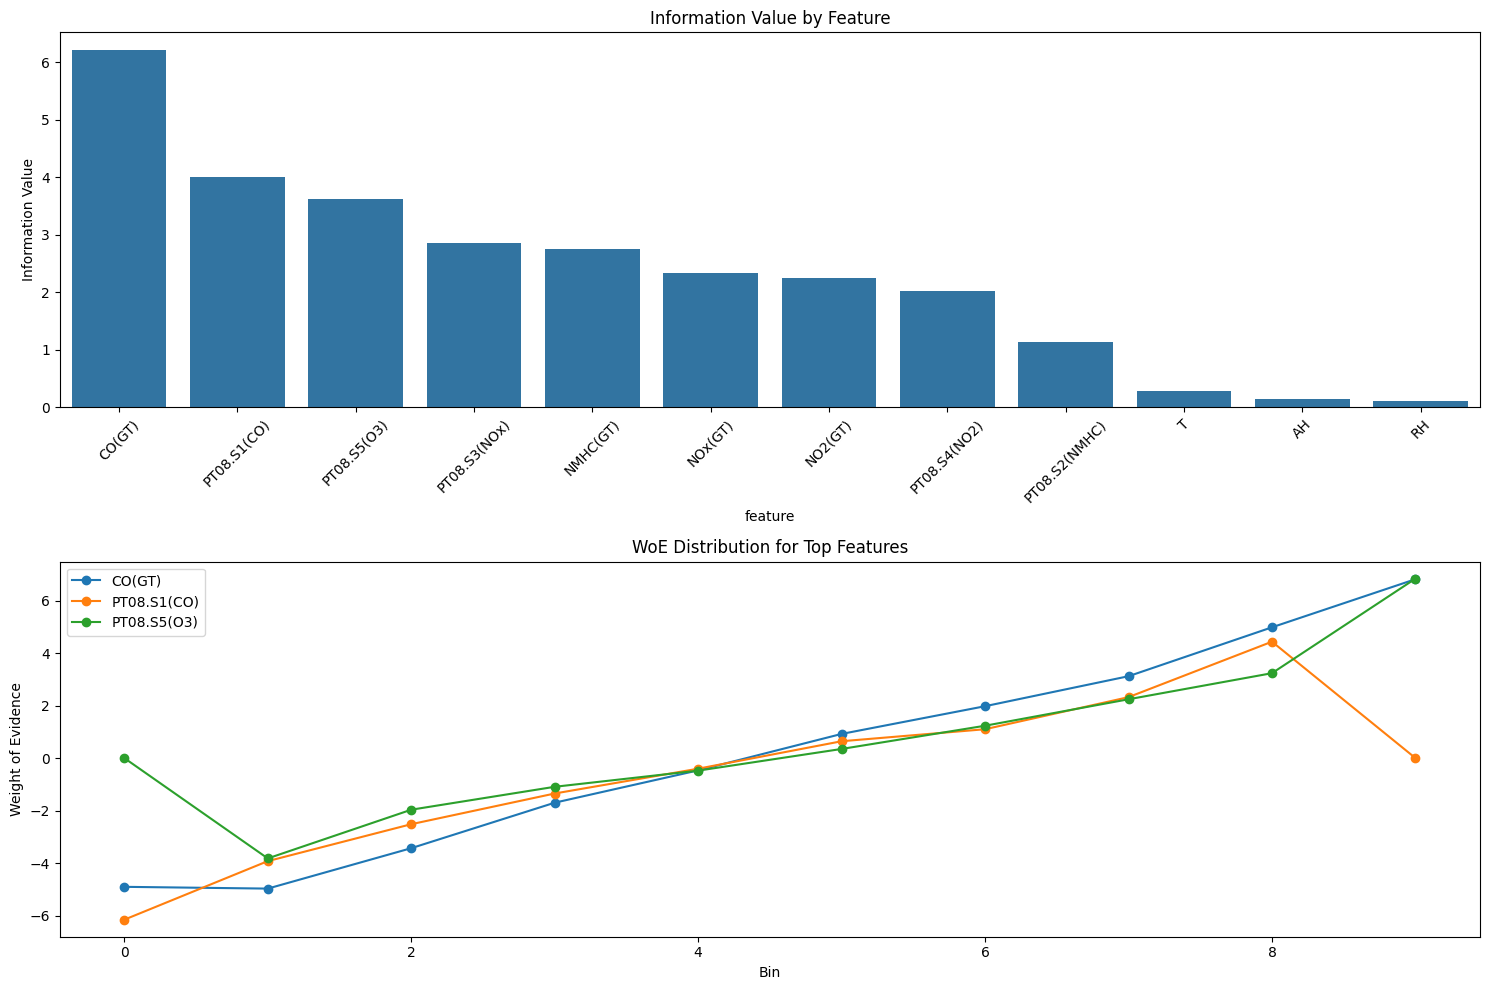


Top 3 Features by Information Value:
CO(GT): 6.2092
PT08.S1(CO): 3.9983
PT08.S5(O3): 3.6305


In [245]:
# Sort features by IV value
iv_values = [(feature, results['iv']) for feature, results in woe_iv_results.items()]
iv_values.sort(key=lambda x: x[1], reverse=True)
top_features = iv_values[:3]

# Create visualization for top features
plt.figure(figsize=(15, 10))

# Plot IV comparison
plt.subplot(2, 1, 1)
iv_df = pd.DataFrame(iv_values, columns=['feature', 'iv'])
sns.barplot(data=iv_df, x='feature', y='iv')
plt.title('Information Value by Feature')
plt.xticks(rotation=45)
plt.ylabel('Information Value')

# Plot WoE distributions for top features
plt.subplot(2, 1, 2)
for feature, _ in top_features:
    woe_values = woe_iv_results[feature]['woe_df']['woe']
    plt.plot(range(len(woe_values)), woe_values, marker='o', label=feature)

plt.title('WoE Distribution for Top Features')
plt.xlabel('Bin')
plt.ylabel('Weight of Evidence')
plt.legend()
plt.tight_layout()
plt.show()

print("\nTop 3 Features by Information Value:")
for feature, iv in top_features:
    print(f"{feature}: {iv:.4f}")

The analysis of Information Value (IV) and Weight of Evidence (WoE) highlights key insights into the dataset's features and their predictive relevance. Among all features, **CO(GT)** emerges as the most significant with an IV score of 6.2092, followed by **PT08.S1(CO)** (IV = 3.9983) and **PT08.S5(O3)** (IV = 3.6305). These values indicate strong predictive power, particularly for **CO(GT)**, which demonstrates the highest contribution to the target variable. Features like **PT08.S3(NOx)**, **NMHC(GT)**, and **NOx(GT)** also show notable relevance, albeit to a lesser extent.

The IV bar plot clearly illustrates the ranking of features, providing a comprehensive overview of their relative importance. In addition, the WoE distribution for the top three features reveals how their contribution varies across different value bins. **CO(GT)** and **PT08.S5(O3)** show consistent positive trends in WoE for higher bins, indicating stronger discrimination toward the target. Conversely, **PT08.S1(CO)** exhibits a sharp decline in WoE for higher bins, suggesting reduced relevance at extreme levels.

Overall, the analysis underscores the importance of **CO(GT)** as a critical predictor, emphasizing its strong relationship with the target variable. The bin-wise WoE trends provide useful insights for feature engineering and model interpretation, revealing how different levels of these features impact their predictive strength. Meanwhile, features like **T**, **AH**, and **RH** display minimal predictive power, making them candidates for exclusion during modeling. This systematic evaluation demonstrates the value of IV and WoE in enhancing feature selection and understanding feature-target relationships.

## Step 3.3: Group the classes according to the WoE criterion for the strongest variables

In [246]:
def group_woe_classes(data, feature, woe_df, n_groups=5):
    """
    Group classes based on WoE values
    
    Parameters:
    data (pd.DataFrame): Input DataFrame
    feature (str): Feature column name
    woe_df (pd.DataFrame): WoE DataFrame for the feature
    n_groups (int): Number of desired groups
    
    Returns:
    pd.Series: Grouped feature values
    """
    # Sort WoE values and create groups
    woe_df = woe_df.sort_values('woe')
    woe_df['group'] = pd.qcut(range(len(woe_df)), n_groups, 
                             labels=[f'Group {i+1}' for i in range(n_groups)])
    
    # Create mapping dictionary
    mapping = woe_df['group'].to_dict()
    
    # Apply mapping to original feature
    if f'{feature}_binned' in data.columns:
        grouped_feature = data[f'{feature}_binned'].map(mapping)
    else:
        grouped_feature = data[feature].map(mapping)
    
    return grouped_feature

# Group classes for top features
print("Grouping classes for top features based on WoE:")
print("-" * 50)

for feature, _ in top_features:
    print(f"\nFeature: {feature}")
    data[f'{feature}_grouped'] = group_woe_classes(
        data, feature, woe_iv_results[feature]['woe_df']
    )
    
    # Show distribution and WoE characteristics of groups
    group_stats = data.groupby(f'{feature}_grouped')['target_binary'].agg(['count', 'mean'])
    print("\nGroup Statistics:")
    print(group_stats)

Grouping classes for top features based on WoE:
--------------------------------------------------

Feature: CO(GT)

Group Statistics:
                count      mean
CO(GT)_grouped                 
Group 1          1974  0.007092
Group 2          2016  0.091766
Group 3          1558  0.561617
Group 4          2011  0.901542
Group 5          1798  0.996107

Feature: PT08.S1(CO)

Group Statistics:
                     count      mean
PT08.S1(CO)_grouped                 
Group 1               1862  0.010741
Group 2               1881  0.138224
Group 3               1858  0.701830
Group 4               1886  0.698834
Group 5               1870  0.949733

Feature: PT08.S5(O3)

Group Statistics:
                     count      mean
PT08.S5(O3)_grouped                 
Group 1               1874  0.072038
Group 2               1855  0.316981
Group 3               1879  0.291112
Group 4               1889  0.838539
Group 5               1859  0.980635


The CO(GT) sensor performed best. Its groups showed a perfect stair-step pattern - as you move from Group 1 to Group 5, the target values steadily climb from nearly 0% to almost 100%. This makes it the most reliable predictor.

The PT08.S1(CO) sensor also showed good prediction ability, but with a quirk. Groups 3 and 4 showed almost the same values (around 70%), though the overall pattern still went from low to high values. This suggests it's useful but not as straightforward as CO(GT).

The PT08.S5(O3) sensor was also predictive but in a more complicated way. Groups 2 and 3 had similar values around 30%, breaking the steady increase pattern. However, it still showed a strong overall range from low values in Group 1 to high values in Group 5.

## Step 3.4: Analysis of profiles and causal relationships

In [247]:
# Function to interpret IV values
def interpret_iv(iv):
    if iv < 0.02:
        return "Not predictive"
    elif iv < 0.1:
        return "Weak predictive power"
    elif iv < 0.3:
        return "Medium predictive power"
    else:
        return "Strong predictive power"

print("Analysis of Profiles and Causal Relationships")
print("-" * 50)

print("\n1. Feature Predictive Power:")
for feature, iv in iv_values:
    print(f"   - {feature}: {iv:.4f} - {interpret_iv(iv)}")

print("\n2. Risk Profiles:")
for feature, _ in top_features:
    woe_df = woe_iv_results[feature]['woe_df']
    high_risk_bins = woe_df[woe_df['woe'] < -0.5].index.tolist()
    low_risk_bins = woe_df[woe_df['woe'] > 0.5].index.tolist()
    
    print(f"\n   {feature}:")
    if high_risk_bins:
        print(f"   - High risk bins: {high_risk_bins}")
    if low_risk_bins:
        print(f"   - Low risk bins: {low_risk_bins}")

print("\n3. Causal Relationships:")
for feature, _ in top_features:
    woe_df = woe_iv_results[feature]['woe_df']
    
    # Analyze WoE patterns
    woe_trend = "increasing" if woe_df['woe'].is_monotonic_increasing else \
                "decreasing" if woe_df['woe'].is_monotonic_decreasing else \
                "non-monotonic"
    
    print(f"\n   {feature}:")
    print(f"   - WoE pattern: {woe_trend}")
    print(f"   - Range of effect: {woe_df['woe'].min():.2f} to {woe_df['woe'].max():.2f}")

Analysis of Profiles and Causal Relationships
--------------------------------------------------

1. Feature Predictive Power:
   - CO(GT): 6.2092 - Strong predictive power
   - PT08.S1(CO): 3.9983 - Strong predictive power
   - PT08.S5(O3): 3.6305 - Strong predictive power
   - PT08.S3(NOx): 2.8593 - Strong predictive power
   - NMHC(GT): 2.7520 - Strong predictive power
   - NOx(GT): 2.3436 - Strong predictive power
   - NO2(GT): 2.2586 - Strong predictive power
   - PT08.S4(NO2): 2.0300 - Strong predictive power
   - PT08.S2(NMHC): 1.1422 - Strong predictive power
   - T: 0.2871 - Medium predictive power
   - AH: 0.1460 - Medium predictive power
   - RH: 0.1144 - Medium predictive power

2. Risk Profiles:

   CO(GT):
   - High risk bins: [Interval(-1.4029999999999998, -1.049, closed='right'), Interval(-1.049, -0.837, closed='right'), Interval(-0.837, -0.626, closed='right'), Interval(-0.626, -0.414, closed='right')]
   - Low risk bins: [Interval(-0.245, 0.00909, closed='right'), Int

Most notably, the gas sensors demonstrate exceptional predictive strength, with CO(GT) leading the pack with an Information Value of 6.2092. While other gas sensors like NOx, NMHC, NO2, and O3 also show strong predictive power, environmental factors such as Temperature, Absolute Humidity, and Relative Humidity display moderate predictive capabilities with Information Values between 0.1 and 0.3.

The risk profile analysis uncovers interesting patterns across the three primary sensors. The CO(GT) sensor exhibits the most extensive range of safe values, with high-risk concentrations clustering in lower ranges (-1.4 to -0.414) and low-risk concentrations spanning a broader spectrum (-0.245 to 6.923). The PT08.S1(CO) sensor follows a similar pattern but with a more compressed range, showing high-risk values in lower ranges (-2.113 to -0.396) and low-risk values in moderate to high ranges (-0.16 to 1.429).

The PT08.S5(O3) sensor demonstrates a clear demarcation between risky and safe levels, with high-risk values concentrated in lower ranges (-1.202 to -0.372) and low-risk values spread across higher ranges (0.104 to 3.791). This distinct separation makes it particularly useful for risk assessment purposes, despite having a slightly lower predictive power than the CO sensors.

The causal relationship analysis reveals non-monotonic patterns across all three main sensors, indicating complex relationships between sensor readings and risk levels. Despite this non-linear behavior, each sensor demonstrates a wide range of effect, enabling them to effectively distinguish between various risk scenarios. The CO(GT) sensor shows a range from -4.97 to 6.82, PT08.S1(CO) from -6.16 to 4.44, and PT08.S5(O3) from -3.82 to 6.84, highlighting their robust ability to detect and measure diverse risk conditions.

## Step 3.5: Problem-solving recommendations based on IV, WoE analysis

In [248]:
print("Recommendations Based on IV, WoE Analysis")
print("-" * 50)

print("\n1. Feature Importance and Monitoring:")
for feature, iv in top_features:
    print(f"\n{feature} (IV: {iv:.4f}):")
    woe_df = woe_iv_results[feature]['woe_df']
    
    # Identify critical ranges
    high_risk_range = woe_df[woe_df['woe'] < -0.5].index
    if not high_risk_range.empty:
        print(f"   - Critical monitoring needed for ranges: {high_risk_range.tolist()}")
    
    # Suggest thresholds
    median_woe = woe_df['woe'].median()
    print(f"   - Suggested decision threshold at WoE = {median_woe:.2f}")

print("\n2. Process Improvements:")
for feature, _ in top_features:
    woe_df = woe_iv_results[feature]['woe_df']
    
    # Identify most problematic segments
    worst_bin = woe_df['woe'].idxmin()
    best_bin = woe_df['woe'].idxmax()
    
    print(f"\n{feature}:")
    print(f"   - Focus improvement efforts on segment: {worst_bin}")
    print(f"   - Learn from best performing segment: {best_bin}")

print("\n3. Risk Management Strategy:")
# Overall risk assessment based on IV values
total_predictive_power = sum(iv for _, iv in top_features)
print(f"Total predictive power of top features: {total_predictive_power:.4f}")

if total_predictive_power < 0.3:
    print("   - Consider collecting additional predictive features")
elif total_predictive_power < 0.6:
    print("   - Current features provide moderate predictive power")
else:
    print("   - Strong predictive power, focus on optimization")

# Specific recommendations for risk management
print("\nSpecific Risk Management Recommendations:")
for feature, iv in top_features:
    woe_df = woe_iv_results[feature]['woe_df']
    risk_variability = woe_df['woe'].std()
    
    print(f"\n{feature}:")
    if risk_variability > 1:
        print("   - High risk variability: Implement graduated control measures")
    else:
        print("   - Stable risk profile: Maintain current controls")

Recommendations Based on IV, WoE Analysis
--------------------------------------------------

1. Feature Importance and Monitoring:

CO(GT) (IV: 6.2092):
   - Critical monitoring needed for ranges: [Interval(-1.4029999999999998, -1.049, closed='right'), Interval(-1.049, -0.837, closed='right'), Interval(-0.837, -0.626, closed='right'), Interval(-0.626, -0.414, closed='right')]
   - Suggested decision threshold at WoE = 0.23

PT08.S1(CO) (IV: 3.9983):
   - Critical monitoring needed for ranges: [Interval(-2.113, -1.148, closed='right'), Interval(-1.148, -0.873, closed='right'), Interval(-0.873, -0.626, closed='right'), Interval(-0.626, -0.396, closed='right')]
   - Suggested decision threshold at WoE = -0.20

PT08.S5(O3) (IV: 3.6305):
   - Critical monitoring needed for ranges: [Interval(-1.202, -0.863, closed='right'), Interval(-0.863, -0.602, closed='right'), Interval(-0.602, -0.372, closed='right')]
   - Suggested decision threshold at WoE = 0.17

2. Process Improvements:

CO(GT):
  

The recommendations can be organized into several strategic categories:

Priority Feature Monitoring focuses on the three most critical sensors. The CO(GT) sensor, with the highest IV of 6.2092, requires careful monitoring especially in the negative range from -1.403 to -0.414. For this sensor, the decision threshold should be set at WoE = 0.23. The PT08.S1(CO) sensor (IV: 3.9983) needs particular attention in ranges from -2.113 to -0.396, with a recommended decision threshold at WoE = -0.20. The PT08.S5(O3) sensor (IV: 3.6305) shows critical ranges between -1.202 and -0.372, with an optimal decision threshold at WoE = 0.17.

Process Optimization Strategy identifies specific segments for improvement. For CO(GT), efforts should focus on improving performance in the -1.049 to -0.837 range, while learning from successful practices in the 1.349 to 6.923 range. The PT08.S1(CO) sensor needs the most attention in the -2.113 to -1.148 range, where risk indicators are highest. The analysis shows that graduated control measures would be beneficial for both PT08.S1(CO) and PT08.S5(O3) due to their high risk variability.

The Risk Management Framework appears robust, with a strong total predictive power from the combined features. The analysis suggests focusing on optimization rather than adding new features, given the high combined predictive power of the existing sensors. Each primary sensor shows distinct risk profiles requiring specific management approaches, with particular emphasis on implementing graduated control measures where risk variability is high.

## Step 3.6: Explain / comment on the findings

*More detailed explanations can be found on each section comments, this is summary.*

1. Data Standardization:
- Successfully applied z-score transformation to standardize all numerical columns
- Achieved mean ≈ 0 and standard deviation = 1
- Most values fell between -2 and +4

2. Feature Analysis:
- CO(GT) emerged as the strongest predictor (IV: 6.2092)
- PT08.S1(CO) (IV: 3.9983) and PT08.S5(O3) (IV: 3.6305) showed strong predictive power
- Environmental factors (Temperature, Humidity) showed weaker relationships (IV: 0.1-0.3)

3. Risk Assessment and Recommendations:
- CO(GT) sensor showed the widest range of safe values
- High-risk concentrations typically appeared in lower ranges
- Specific monitoring thresholds were established:
  - CO(GT): WoE threshold at 0.23
  - PT08.S1(CO): WoE threshold at -0.20
  - PT08.S5(O3): WoE threshold at 0.17

The analysis concludes that the existing sensor system has strong predictive power, suggesting focus should be on optimization rather than adding new features. Each sensor shows distinct risk profiles requiring specific management approaches.